In [92]:
%matplotlib inline

import openslide
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = 12, 12
res = 8

In [93]:
c="D:/dataThomas/Projet_FR-TNBC-2015-09-30/All/*tiff"

In [95]:
import glob
c = glob.glob(c)[30]

IndexError: list index out of range

In [96]:
import UsefulOpenSlide as UOS

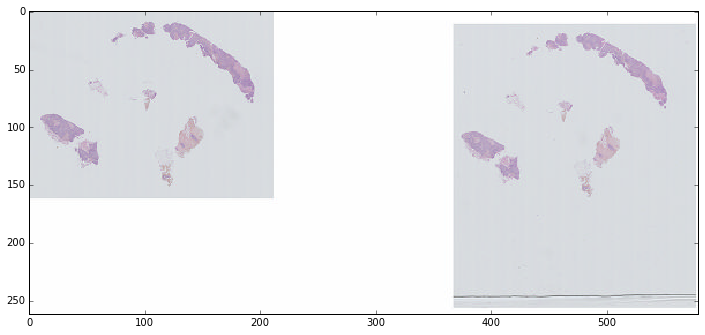

In [97]:
sample = UOS.GetWholeImage(c, level = res)
plt.imshow(sample)


In [98]:
np_sample = np.array(sample)
np_sample[:,:,3] = np_sample[:,:,0:3].mean(axis=2)

np_sample.shape

(262L, 580L, 4L)

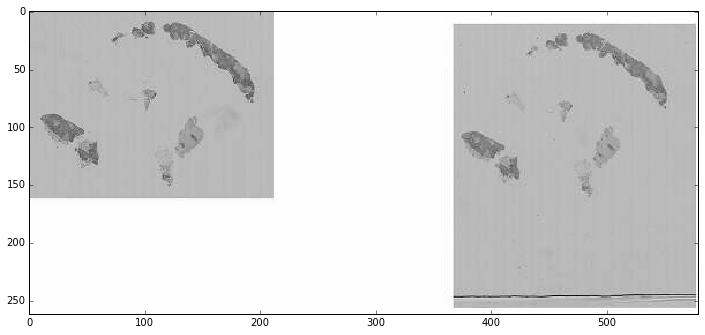

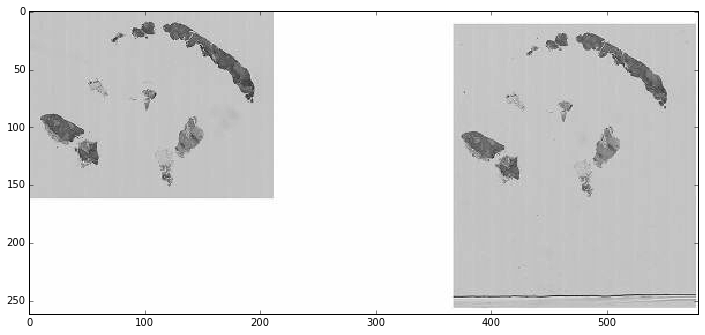

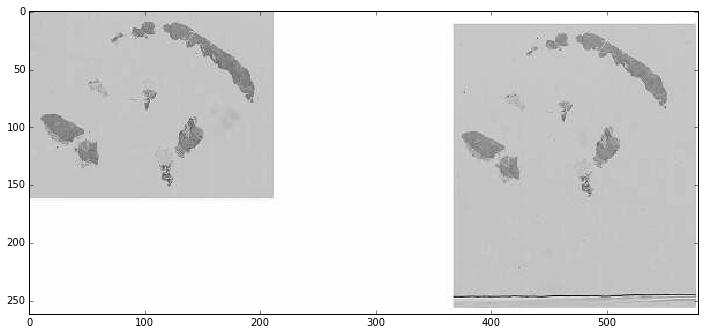

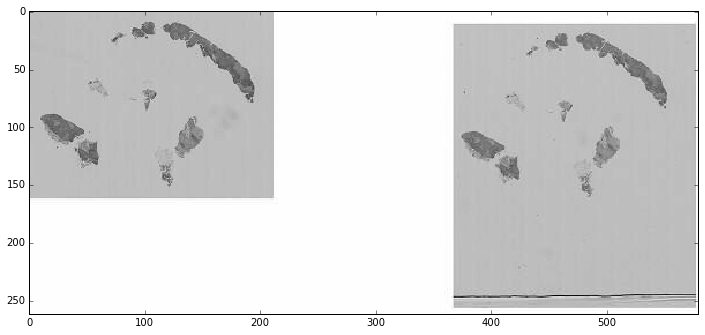

In [99]:
for i in range(4):
    plt.imshow(np_sample[:,:,i])
    plt.show()

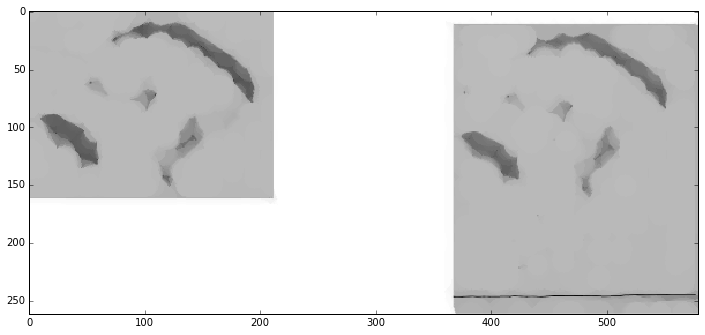

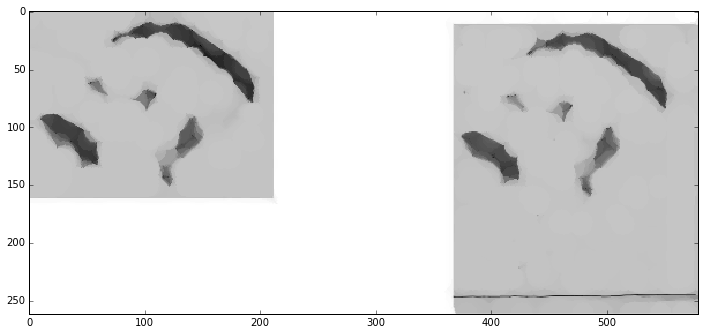

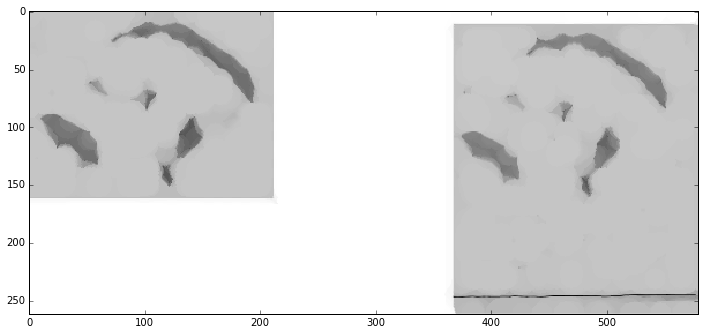

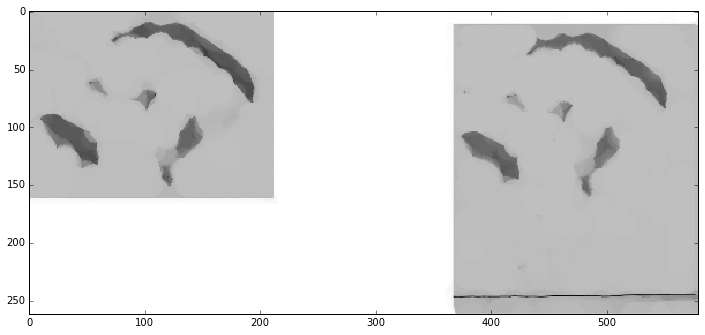

In [100]:
from skimage.morphology import disk, closing, opening
selem = disk(6)
def special(image, iteration = 10):
    inter_image = image.copy()
    for i in range(iteration):
        inter_image = opening(inter_image,disk(i))
    return inter_image

for i in range(4):
    plt.imshow(special(np_sample[:,:,i]))
    plt.show()


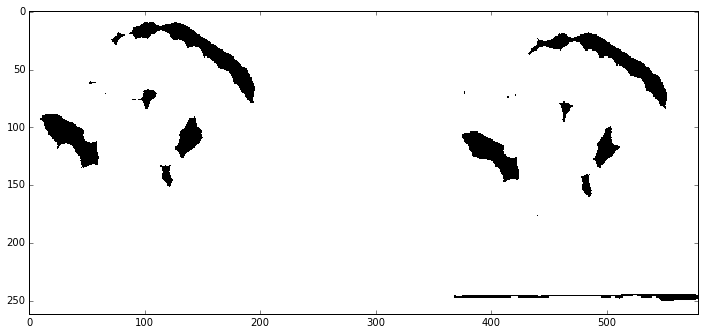

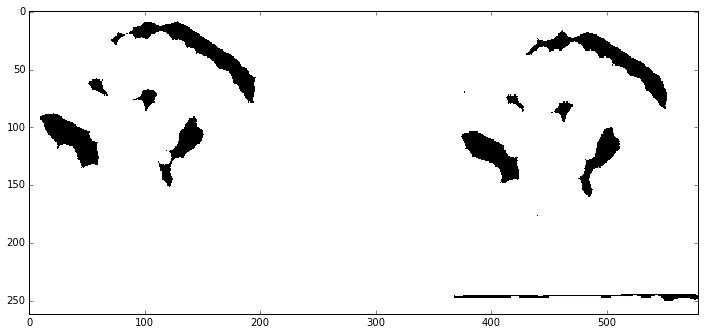

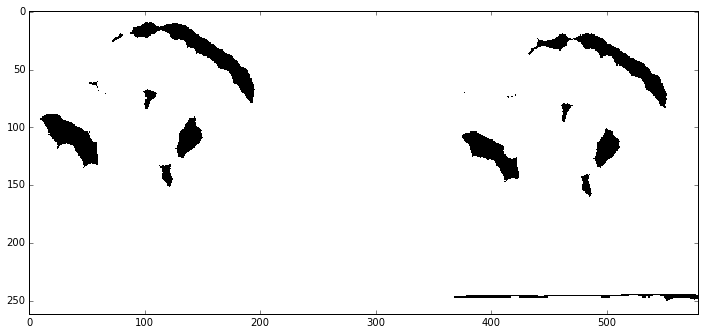

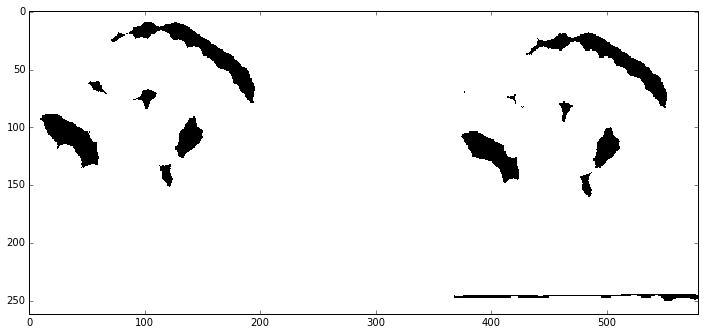

In [101]:
from skimage.filters import threshold_otsu
def TissueMask(image, thresh = None):
    ## tissue is in black... Tries to find the best background
    if thresh is None:
        thresh = threshold_otsu(image)
    binary = image > thresh
    if binary.dtype=='bool':
        binary=binary+0
    return binary

for i in range(4):
    plt.imshow(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200))
    plt.show()


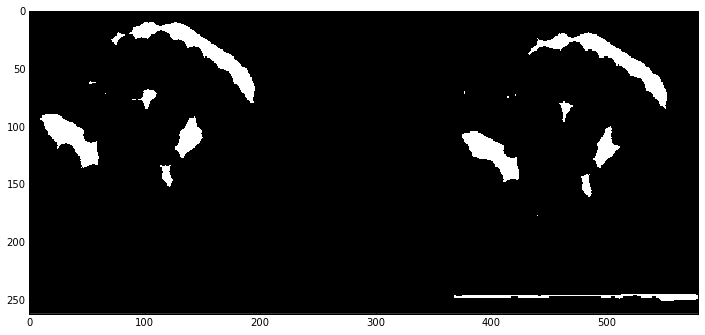

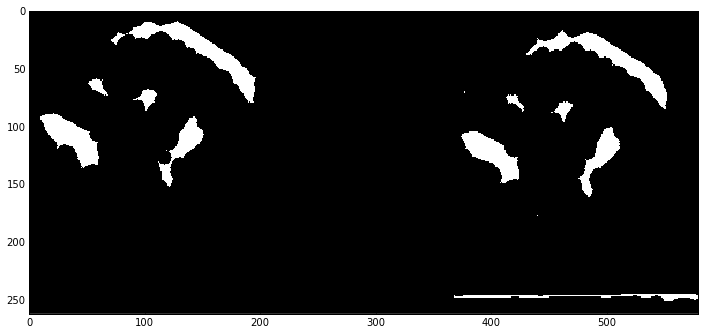

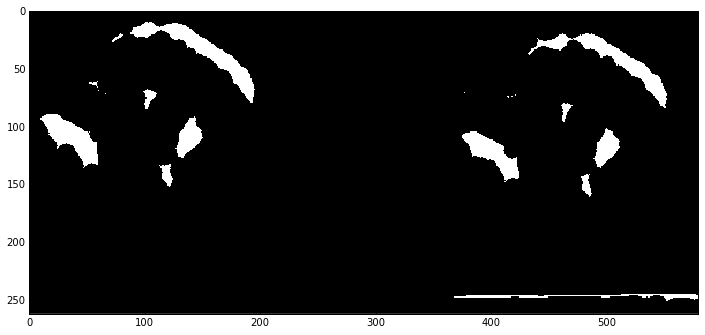

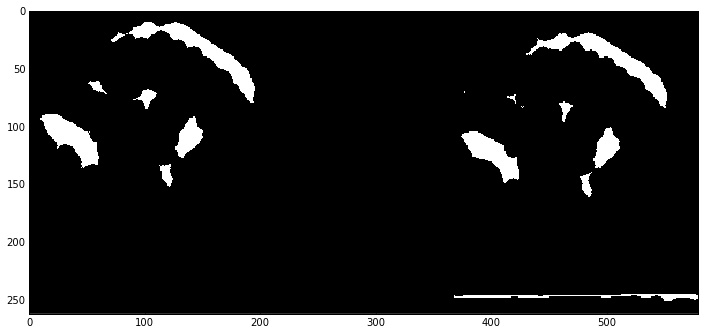

In [102]:
import pdb
from skimage.morphology import reconstruction
from scipy.ndimage.morphology import binary_fill_holes, morphological_gradient
def Filling_holes(image, seed_image = None):
    seed = np.copy(image)
    
    ##I was here... 
    pdb.set_trace()
    if seed_image is not None:
        seed[1:-1, 1:-1] = seed_image.max()
    else:
        seed[1:-1, 1:-1] = image.max()
        
    mask = image

    filled = reconstruction(seed, mask, method='erosion')
    return filled

def Filling_holes_2(bin_image, invert = False):
    values = np.unique(bin_image)
    if len(values) > 2:
        print "Not binary image"
        return []
    background = min(values)
    bin_image -= background
    bin_image[bin_image > 0] = 1
    if invert:
        bin_image -=1
        bin_image[bin_image < 0] =1
    result = np.copy(bin_image)
    binary_fill_holes(bin_image, output = result)
    return result



for i in range(4):
    #plt.imshow(Filling_holes(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200), seed_image = np_sample[:,:,i]))
    plt.imshow(Filling_holes_2(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200), invert = True))
    plt.show()


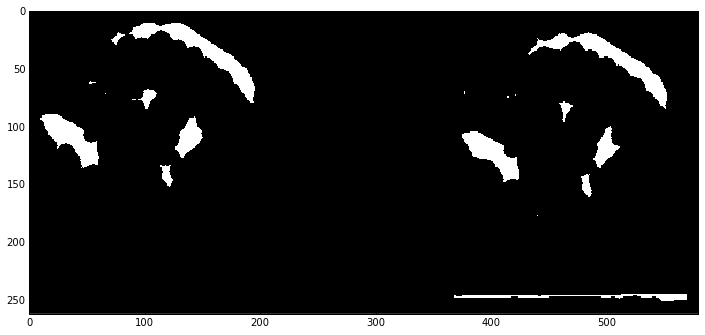

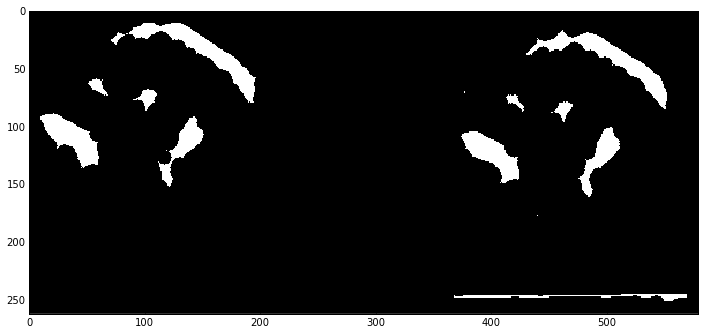

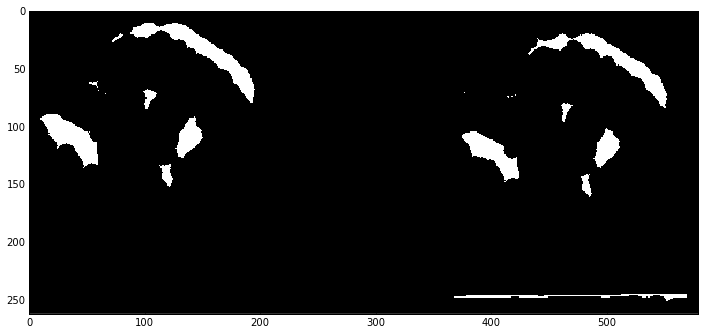

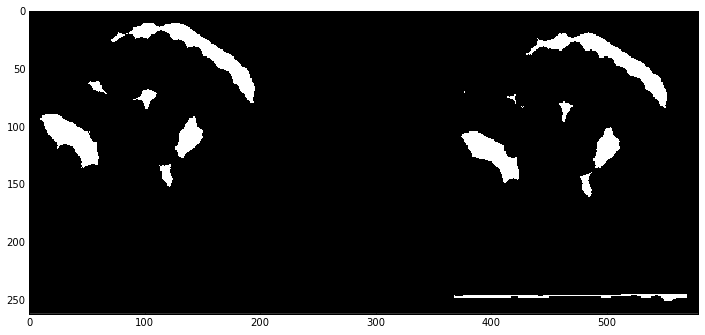

In [103]:
def remove_border(image_bin, border = 5):
    neg_border = border * -1
    result = np.copy(image_bin)
    result[:,:] = 0
    result[border:neg_border, border:neg_border] = image_bin[border:neg_border, border:neg_border]
    return result
    
    

for i in range(4):
    #plt.imshow(Filling_holes(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200), seed_image = np_sample[:,:,i]))
    plt.imshow(remove_border(Filling_holes_2(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200), invert = True), border = 10))
    plt.show()

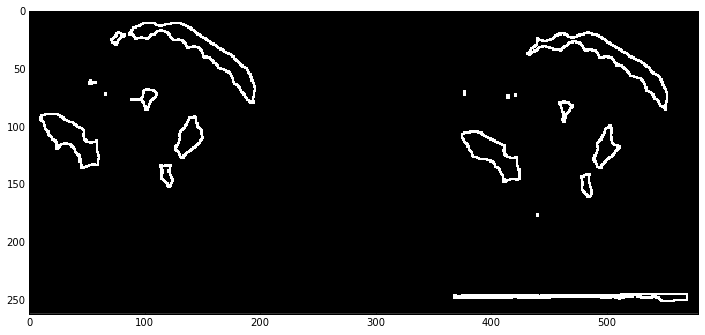

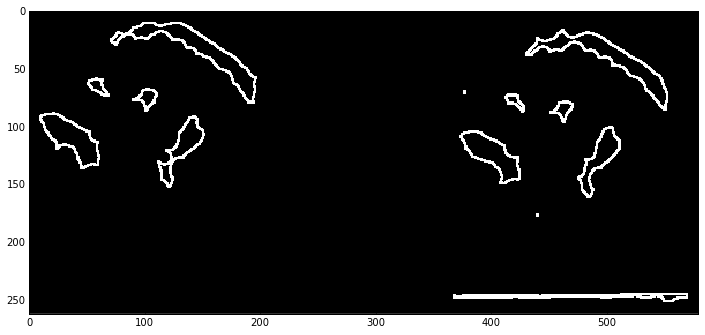

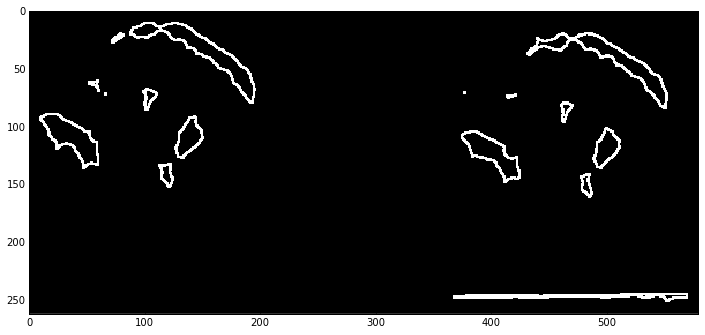

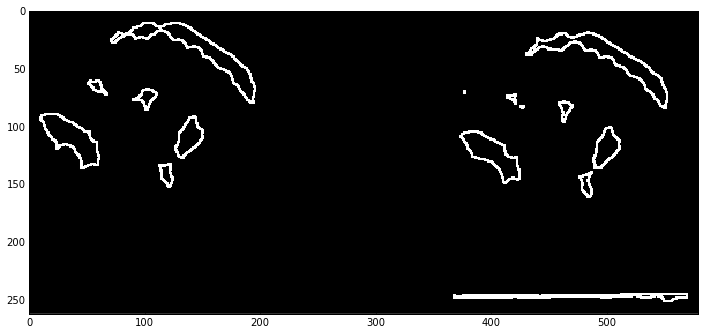

In [104]:

def Contours(bin_image, contour_size = 3):
    grad = morphological_gradient(bin_image, size=(contour_size,contour_size))
    return grad 

for i in range(4):
    
    ROI = remove_border(Filling_holes_2(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200), invert = True), border = 10)

    #plt.imshow(Filling_holes(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200), seed_image = np_sample[:,:,i]))
    plt.imshow(Contours(ROI))
    plt.show()

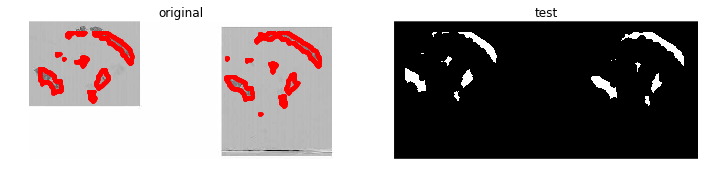

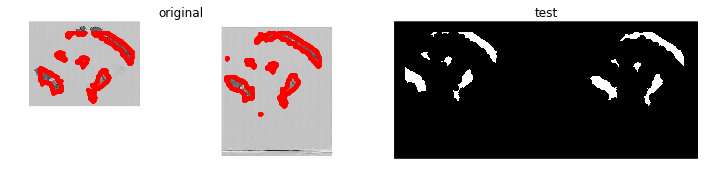

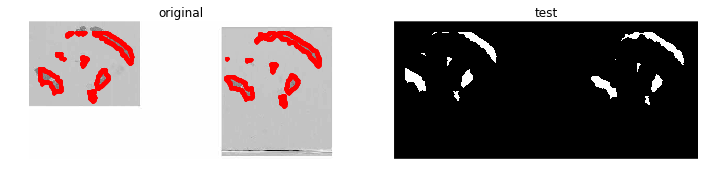

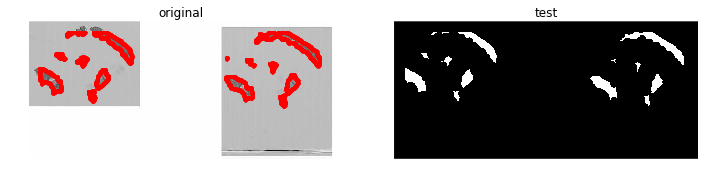

In [105]:
def plot_comparison(original, mask, contour = None, filter_name = None):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 12), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    if contour is not None:
        x,y =np.where(contour > 0)
        ax1.plot(y,x, '.r')
        #pdb.set_trace()
    ax1.set_adjustable('box-forced')
    ax2.imshow(mask, cmap=plt.cm.gray)
    if filter_name is not None:
        ax2.set_title(filter_name)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    plt.show()
    
for i in range(4):
    
    ROI = remove_border(Filling_holes_2(TissueMask(special(np_sample[:,:,i], iteration = 7 ), 200), invert = True), border = 20)
    cont = Contours(ROI)
    plot_comparison(np_sample[:,:,i], mask = ROI, contour = cont, filter_name = 'test')

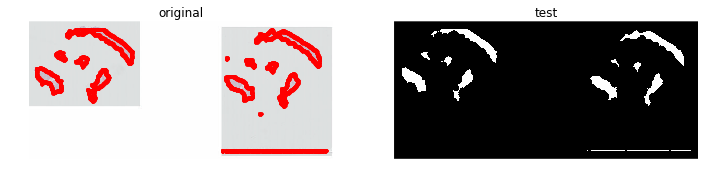

In [106]:


def combining(numpy_array):
    x, y, z = numpy_array.shape
    res = np.sum(numpy_array, axis = 2)
    res[res>0] = 1
    return res

Pre_Final = np.copy(np_sample)
for i in range(Pre_Final.shape[2]):
    #pdb.set_trace()
    channel = np_sample[:,:,i]
    tissue_enhanced = special(channel, iteration = 7 )
    tissue_cut = TissueMask(tissue_enhanced, 200)
    filled_in = Filling_holes_2(tissue_cut, invert = True)
    bordeless = remove_border(filled_in, border = 15)
    Pre_Final[:,:,i] = bordeless

Final = combining(Pre_Final)
cont = Contours(Final)
plot_comparison(np_sample, mask = Final, contour = cont, filter_name = 'test')


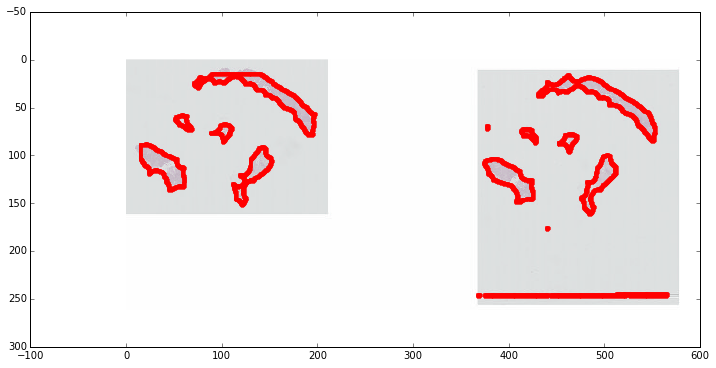

In [107]:
from matplotlib.pyplot import savefig
def save(original, contour = None, name = "random_picture.png"):

    plt.imshow(original)
    if contour is not None:
        x,y =np.where(contour > 0)
        plt.plot(y,x, '.r')
        #pdb.set_trace()
    #plt.set_adjustable('box-forced')
    savefig(name, bbox_inches='tight')
    
save(np_sample[:,:,0:3],cont,"test.png")